# Punks Gen w/ Conditional VAE

In [1]:
import sys
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


# Settings

In [3]:
SAVE_NAME = 'cvae.naive'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(notebook=True)


<Logger pallets (INFO)>

## Prepare Datasets

In [6]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.OneHotCPunksDataset(
#     mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../artifacts/onehot_ds_cpu.pt')

dataset = torch.load('../artifacts/onehot_ds_cpu.pt')

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)


## CVAE

In [8]:
input_dim = 24 * 24 * 222
hidden_dim = 576
latent_dim = 32
classes_dim = 92


model = M.cvae.CVAE(input_dim, hidden_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()


In [9]:

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)


INFO | model: pallets.models.cvae.CVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1422177.375000
INFO | epoch 1 ( 35%) loss: 92106.045299
INFO | epoch 1 ( 70%) loss: 51946.647364
INFO | epoch 1 (100%) loss: 39234.954006
INFO | epoch 1 (test) loss: 6571.292175
INFO | epoch 2 (  0%) loss: 6257.865234
INFO | epoch 2 ( 35%) loss: 5917.445535
INFO | epoch 2 ( 70%) loss: 5559.684808
INFO | epoch 2 (100%) loss: 5192.472444
INFO | epoch 2 (test) loss: 3872.834715
INFO | epoch 3 (  0%) loss: 4005.198730
INFO | epoch 3 ( 35%) loss: 3677.484544
INFO | epoch 3 ( 70%) loss: 3449.029907
INFO | epoch 3 (100%) loss: 3290.213835
INFO | epoch 3 (test) loss: 2751.105015
INFO | epoch 4 (  0%) loss: 2829.996826
INFO | epoch 4 ( 35%) loss: 2644.205900
INFO | epoch 4 ( 70%) loss: 2524.381029
INFO | epoch 4 (100%) loss: 2428.236728
INFO | epoch 4 (test) loss: 2082.985722
INFO | epoch 5 (  0%) loss: 2260.326172
INFO | epoch 5 ( 35%) loss: 2

In [10]:
M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model blob saved to /home/jmsdnns/ML/pallets/saved/cvae.naive.pkl
INFO | training losses saved to /home/jmsdnns/ML/pallets/saved/cvae.naive.json


# Model Output to Image

In [11]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)
# model = model.to(device)


#

In [12]:
import random
import json

raw_labels = json.load(open("../artifacts/pallets_labels.json"))
label_keys = [k for k in raw_labels["0"].keys()]

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [13]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms

Features: female, greenEyeShadow, bandana, purpleLipstick, cigarette
Shape: torch.Size([4, 24, 24])


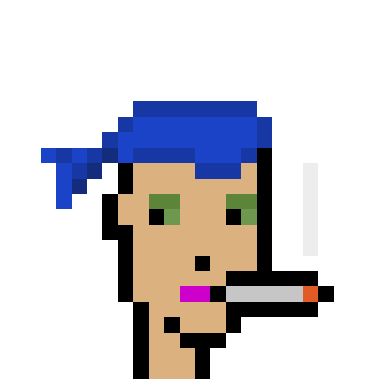

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, straightHairBlonde, hornedRimGlasses, blackLipstick
Shape: torch.Size([4, 24, 24])


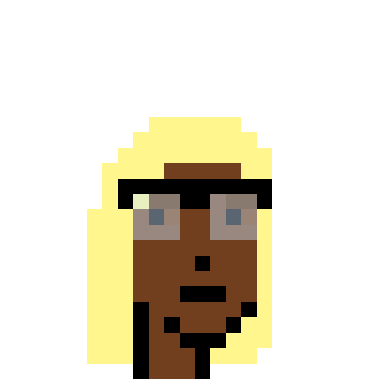

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, chinstrap, mohawk, classicShades
Shape: torch.Size([4, 24, 24])


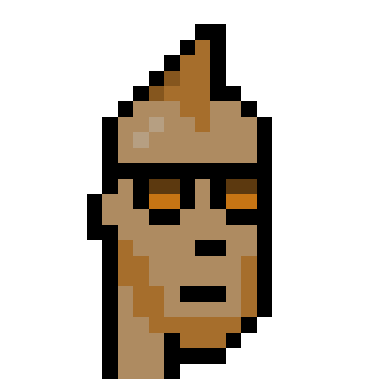

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, blondeShort, blueEyeShadow
Shape: torch.Size([4, 24, 24])


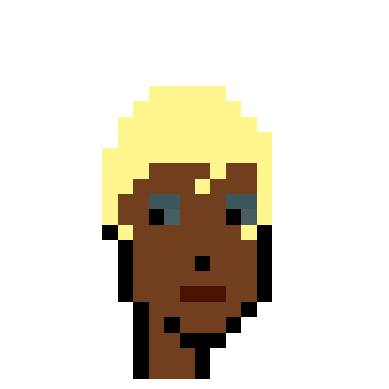

In [17]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, normalBeard, mohawkDark, earring
Shape: torch.Size([4, 24, 24])


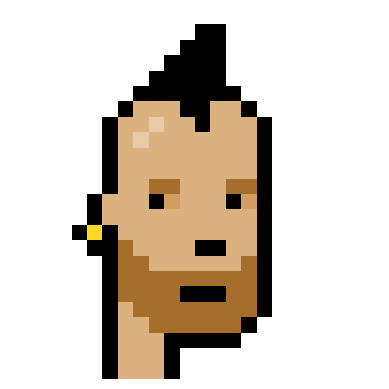

In [18]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [19]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Recons

Features: female, rosyCheeks, darkHair, cigarette


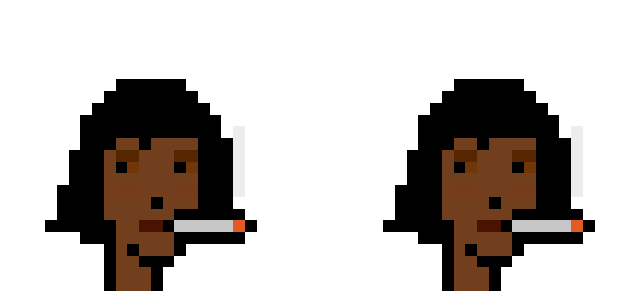

In [20]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


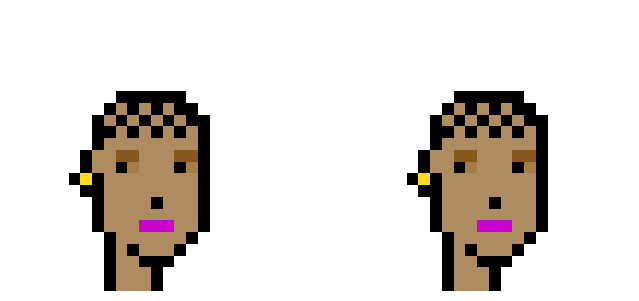

In [21]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


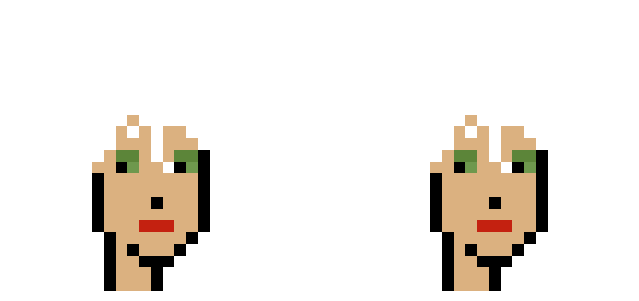

In [22]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


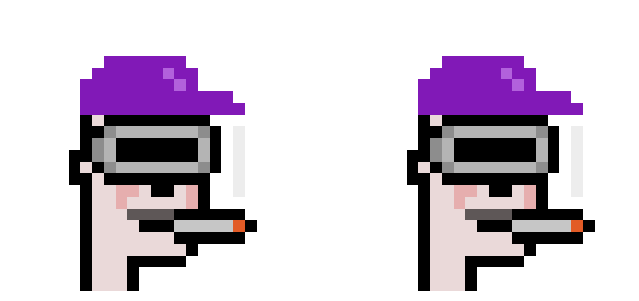

In [23]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


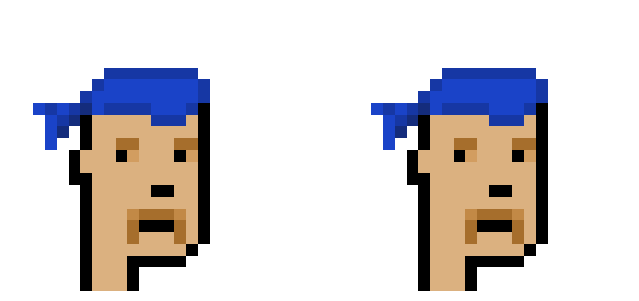

In [24]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

# Testing

<function matplotlib.pyplot.show(close=None, block=None)>

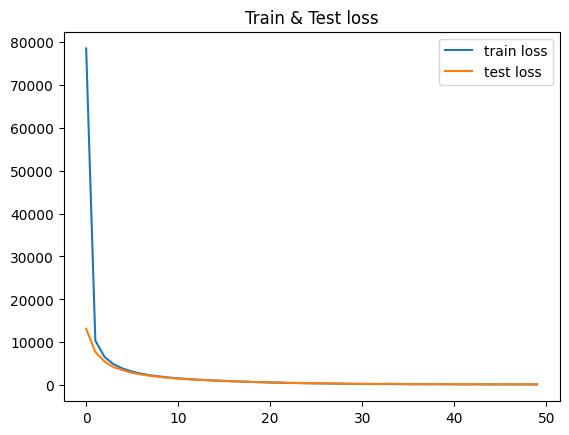

In [25]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [26]:
train_losses


[78469.90801266069,
 10384.94488828402,
 6580.427669011109,
 4856.473455983696,
 3857.9328427145665,
 3167.303592330175,
 2663.898777522094,
 2293.0274723134144,
 2022.129860086644,
 1783.8197913203678,
 1596.2845698146955,
 1453.0905972744556,
 1305.6157455985428,
 1193.3970975402399,
 1085.3178404679536,
 998.43264824617,
 901.4158971258935,
 831.5728144003144,
 753.8379018797096,
 704.4708080968113,
 634.9807812846299,
 581.8745333083133,
 536.0199273833147,
 498.5735132744972,
 453.9677823655149,
 428.0924604699967,
 386.12194569905597,
 371.47137635143093,
 335.5392375432008,
 314.9120096788339,
 296.8139039979759,
 271.85051748938594,
 259.4445785089587,
 260.0765958745429,
 240.34334220615685,
 221.38782925977773,
 218.89725585017644,
 205.34172501800754,
 212.98756474975153,
 212.74887983173343,
 191.69680116531697,
 185.58895451971824,
 196.01403364898465,
 190.91498155796782,
 179.64503737375247,
 188.62464485439003,
 177.10142318238604,
 189.642760784068,
 181.64397594100194

In [27]:
test_losses


[13142.584350585938,
 7745.669429779053,
 5502.210029602051,
 4165.9714431762695,
 3494.500141143799,
 2864.127311706543,
 2482.0456581115723,
 2159.706178665161,
 1905.8528966903687,
 1709.606985092163,
 1506.1039600372314,
 1379.40403175354,
 1255.9241018295288,
 1163.1885719299316,
 1079.0677871704102,
 979.6611561775208,
 904.1474494934082,
 822.8531937599182,
 757.1254873275757,
 690.9239044189453,
 643.2263851165771,
 633.5097146034241,
 535.936665058136,
 518.3980898857117,
 465.8140733242035,
 451.10904026031494,
 425.93568563461304,
 392.3966934680939,
 347.0048031806946,
 336.65829157829285,
 314.7080146074295,
 308.82040882110596,
 285.69419741630554,
 333.9144096374512,
 294.66436076164246,
 259.8343276977539,
 241.23825097084045,
 242.22827744483948,
 274.68986225128174,
 219.14530897140503,
 238.67613577842712,
 219.07793474197388,
 231.26172769069672,
 232.91118049621582,
 200.6614307165146,
 207.6809070110321,
 241.89814591407776,
 213.36965441703796,
 204.6396900415420